## Data pre-preparation code 
this notebook is mainly used for data preparation... 
main goal is to be reproducible for the main notebook!

## Contants, helpers and other functions
This section contains functions that are either reused in multiple places or just don't belong to any of the sections

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#if set to true only samples will be loaded not the full datasets
testmode = True

#default file names to load and save
players_fn = 'Players'
ratings_early_fn = 'RatingsRanksTitlesearlier'
ratings_late_fn = 'Ratingsrankstitleslater'

#file names for temporary saves
ratings_early_grouped_fn = 'ratings_early_grouped'
ratings_later_grouped_fn = 'ratings_later_grouped'

#output file name for consolidated player list
players_with_rating_fn = 'players_with_rating'

#grouped games temp output
id_year_grouped_games = 'yearly_grouped_games_for_id'

#games pgn file
games_fn = 'games'

In [3]:
minimum_years_seen = 2  #number of years a player has to have games for analysis
minimum_games = 10 #number of games one has to have across the years seen

In [4]:
#returns the filename based on whether the code runs in test more or not. By default it will return csv extension
def getfilename(fn, extension = 'csv'):
    if testmode:
        fn = fn + '_sample'
    if extension == 'csv':
        fn = fn + '.csv'
    else:
        fn = fn + '.' + extension
    return fn

## Players list
loading 3 files:
- Players.csv
- RatingsRanksTitlesearlier.csv
- RatingsRanksTitleslater.csv

building up a single dataframe with:
- player name
- date of birth if known
- year of first seen
- year last seen
- maximum rating over the whole period

Given that the 2 ratings files are huge, an aggregated interim version will be saved.
Those 2 files are gouped by ID

In [5]:
fn = getfilename(players_fn)
players_all = pd.read_csv(fn, sep=';')
    
#renaming IDNumber to IDnumber to be able to join on it later
players_all.rename(columns={'IDNumber':'IDnumber'}, inplace = True)
players_all

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00
2,14400057,Kurajica,Bojan,M,1947.11.15 0:00:00,1970.12.31 0:00:00
3,14500477777,Minic,Dragoljub,M,1937.3.5 0:00:00,1970.12.31 0:00:00
4,14500159,Marangunic,Srdjan,M,1943.10.31 0:00:00,1970.12.31 0:00:00
...,...,...,...,...,...,...
1204,600210,Seret,Jean-Luc,M,1951.9.14 0:00:00,1974.5.1 0:00:00
1205,101133,Aparicio,Anibal,M,1947.6.16 0:00:00,1974.5.1 0:00:00
1206,13600290777,Kalatozishvili,Guram,M,1937.5.11 0:00:00,1974.5.1 0:00:00
1207,1400428,Moller,Lars,M,NaN,1974.5.1 0:00:00


In [6]:
players_all[ (players_all['LastName'] == 'Carlsen') & (players_all['FirstName'] == 'Magnus') ]

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist


## Loading early ratings list...
this list contains 14.2 millions ratings data as person appears or can appear on every single quartely or yearly list as long as he or she is active

Converting this huge list to a more manageable size, where each person (ID) has only one row:
- ID
- Country
- Max rating - so games can be filtered for a given minimum or maximum level if needed
- First seen on the list - to be able to filter people who have enough games 
- Last seen  - to be able to filter people who have enough games 

In [7]:
def loadRatingList(filename):
    #loads the input file, replaces decimal 'point' and returns the dataframe
    dtypes = {'IDnumber': 'str', 'Title': 'str', 'WomensTitle':'str', 'Country':'str', 'Rating':'str', 'Games':'str', 'RatingDate': 'str' }
    df = pd.read_csv(filename, sep=';', dtype=dtypes)
    
    #replacing comma with decimal
    df['Rating'] = df['Rating'].str.replace(',','.')
    df['Games'] = df['Games'].str.replace(',','.')

    #filling rating and games nan with 0s
    df['Rating'].fillna(0.00, inplace=True)
    df['Games'].fillna(0.00, inplace=True)
    
    #converting column types    
    df['IDnumber'] = df['IDnumber'].astype(int)
    df['Rating'] = df['Rating'].astype(float)
    df['Games'] = df['Games'].astype(float)    
    
    return df

In [8]:
def saveFile(filename, df):
    df.to_csv(filename, sep=',', encoding = 'utf-8')

In [9]:
def apply_grouping(x, sequence = 1):
    #grouping function for ratings aggregation
    #grouping by id, taking max rating, first seen, last seen
    columns = { 
        'country' : 'country', 
        'rating' : 'max_rating',
        'games' : 'games',
        'first_seen' : 'first_seen',
        'last_seen' : 'last_seen'}
    
    
    #add a trailing index to keys
    columns = {x: columns[x]+str(sequence) for x in columns }
    
    d = {}
    d[ columns['country'] ] = x['Country'].any()
    d[columns['rating']] = x['Rating'].max()
    d[columns['games']] = x['Games'].sum()
    d[columns['first_seen']] = x['RatingDate'].min()
    d[columns['last_seen']] = x['RatingDate'].max()
    return pd.Series(d)


In [10]:
#loading ratings list from 1970 to 2016
fn = getfilename(ratings_early_fn)

ratings_earlier = loadRatingList(fn)


In [11]:
ratings_earlier['Rating'].sum() #test ratings are read as numbers

2614700.0

In [12]:
#grouping by ID and aggregating other data points
grouped_earlier = ratings_earlier.groupby(['IDnumber'], sort=False).apply(apply_grouping)

In [13]:
grouped_earlier.sort_values('first_seen1') #test grouping result

,country1,max_rating1,games1,first_seen1,last_seen1
IDnumber,,,,,
322083,CZE,2012.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00
618390,FRA,2030.0,1.0,2010.11.1 0:00:00,2010.11.1 0:00:00
3800377,PER,2030.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00
620343,FRA,2030.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00
1127802,POL,2030.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00
...,...,...,...,...,...
35015672,IND,1219.0,3.0,2016.6.1 0:00:00,2016.6.1 0:00:00
35094157,IND,1105.0,4.0,2016.6.1 0:00:00,2016.6.1 0:00:00
25015230,IND,1150.0,0.0,2016.6.1 0:00:00,2016.6.1 0:00:00


In [14]:
#saving the file for linking, so no need to regroup again
fn = getfilename(ratings_early_grouped_fn)

saveFile(fn, grouped_earlier)


## Loading later ratings list...
this list contains 14.2 millions ratings data as person appears or can appear on every single quartely or yearly list as long as he or she is active

Converting this huge list to a more manageable size, where each person (ID) has only one row:

- ID
- Country
- Max rating - so games can be filtered for a given minimum or maximum level if needed
- First seen on the list - to be able to filter people who have enough games
- Last seen - to be able to filter people who have enough games

In [15]:
fn = getfilename(ratings_late_fn)

ratings_later = loadRatingList(fn)
grouped_later = ratings_later.groupby(['IDnumber'], sort=False).apply(apply_grouping,2)

In [16]:
grouped_later.sort_values('first_seen2')

,country2,max_rating2,games2,first_seen2,last_seen2
IDnumber,,,,,
1701150,SWE,2135.0,0.0,2016.10.1 0:00:00,2016.10.1 0:00:00
3600416,ECU,2135.0,0.0,2016.10.1 0:00:00,2016.10.1 0:00:00
4900570,MGL,2135.0,0.0,2016.10.1 0:00:00,2016.10.1 0:00:00
12507806,IRI,2135.0,0.0,2016.10.1 0:00:00,2016.10.1 0:00:00
1602128,AUT,2135.0,0.0,2016.10.1 0:00:00,2016.10.1 0:00:00
...,...,...,...,...,...
4142586,RUS,2512.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
14500086,CRO,2512.0,9.0,2016.9.1 0:00:00,2016.9.1 0:00:00
14104490,UKR,2512.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00


In [17]:
fn = getfilename(ratings_later_grouped_fn)

saveFile(fn, grouped_later)

## Combining player and rating lists
#combinig the player database can be essentially used for rating filtering and country mapping -> geographical display and filtering

In [18]:
grouped_earlier = grouped_earlier.reset_index()
grouped_earlier['IDnumber'] = grouped_earlier['IDnumber'].astype(int)
grouped_later = grouped_later.reset_index()
grouped_later['IDnumber'] = grouped_later['IDnumber'].astype(int)

In [19]:
players_with_rating = players_all.merge(grouped_earlier, on='IDnumber', how='left')
players_with_rating = players_with_rating.merge(grouped_later, on='IDnumber', how='left')
players_with_rating.sort_values('max_rating1', ascending = False)

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,country1,max_rating1,games1,first_seen1,last_seen1,country2,max_rating2,games2,first_seen2,last_seen2
429,5000092,Aaron,Manuel,M,1935.12.30 0:00:00,1970.12.31 0:00:00,IND,2315.0,0.0,2016.6.1 0:00:00,2016.6.1 0:00:00,NaN,NaN,NaN,NaN,NaN
69,600687,Zinser,Sylvain,M,1936.11.24 0:00:00,1970.12.31 0:00:00,FRA,2295.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00,NaN,NaN,NaN,NaN,NaN
602,1707434,Josefsson,Kenneth,M,1938.4.22 0:00:00,1972.7.1 0:00:00,SWE,2029.0,0.0,2010.11.1 0:00:00,2010.11.1 0:00:00,NaN,NaN,NaN,NaN,NaN
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,600210,Seret,Jean-Luc,M,1951.9.14 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1205,101133,Aparicio,Anibal,M,1947.6.16 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,13600290777,Kalatozishvili,Guram,M,1937.5.11 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1207,1400428,Moller,Lars,M,NaN,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
players_with_rating.sort_values('country2', ascending = False)

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,country1,max_rating1,games1,first_seen1,last_seen1,country2,max_rating2,games2,first_seen2,last_seen2
597,2000431,Biyiasas,Peter,M,1950.11.19 0:00:00,1972.7.1 0:00:00,NaN,NaN,NaN,NaN,NaN,USA,2450.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
738,2000156,Alburt,Lev O,M,1945.8.21 0:00:00,1973.7.1 0:00:00,NaN,NaN,NaN,NaN,NaN,USA,2539.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
257,2000415,Lombardy,William J,M,1937.12.4 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN,USA,2435.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
1039,2000466,Weinstein,Norman,M,1950.10.4 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,USA,2450.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
1042,2000296,Meyer,Eugene B,M,1952.6.27 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,USA,2443.0,0.0,2016.9.1 0:00:00,2016.9.1 0:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,600210,Seret,Jean-Luc,M,1951.9.14 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1205,101133,Aparicio,Anibal,M,1947.6.16 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1206,13600290777,Kalatozishvili,Guram,M,1937.5.11 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1207,1400428,Moller,Lars,M,NaN,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preparing the consolidated player list 
with single maximum rating and seen dates
taking the min of first seen dates, the max of last seen dates and the max of ratings
there is no check on the country data, if the first is set then it's taken, if not, then the second, regardless of value

In [21]:
#todo - rework this to be generic, this is ugly

def consolidate_player_country(row):
    if not pd.isna(row['country1']):
        return row['country1']
    else:
        return row['country2']

def consolidate_player_rating(row):
    if not pd.isna(row['max_rating1']):
        if pd.isna(row['max_rating2']) or row['max_rating1'] > row['max_rating2']:
            return row['max_rating1']
        
    return row['max_rating2']

def consolidate_player_games(row):
    if not pd.isna(row['games1']):
        if pd.isna(row['games2']) or row['games1'] > row['games2']:
            return row['games1']
    return row['games2']
    
def consolidate_player_first_seen(row):
    if not pd.isna(row['first_seen1']):
        if pd.isna(row['first_seen2']) or row['first_seen1'] < row['first_seen2']:
            return row['first_seen1']
    return row['first_seen2']

def consolidate_player_last_seen(row):
    if not pd.isna(row['last_seen1']):
        if pd.isna(row['last_seen2']) or row['last_seen1'] > row['last_seen2']:
            return row['last_seen1']
    return row['last_seen2']


In [22]:
players_with_rating['country'] = players_with_rating.apply(consolidate_player_country, axis=1)
players_with_rating['max_rating'] = players_with_rating.apply(consolidate_player_rating, axis=1)
players_with_rating['games'] = players_with_rating.apply(consolidate_player_games, axis=1)
players_with_rating['first_seen'] = players_with_rating.apply(consolidate_player_first_seen, axis=1)
players_with_rating['last_seen'] = players_with_rating.apply(consolidate_player_last_seen, axis=1)
#dropping old colums
players_with_rating.drop(columns = ['country1', 'country2', 'max_rating1', 'max_rating2', 'games1', 'games2', 'first_seen1', 'first_seen2', 'last_seen1', 'last_seen2'], inplace = True )
players_with_rating

,IDnumber,LastName,FirstName,Sex,DOB,Firstonlist,country,max_rating,games,first_seen,last_seen
0,14400316,Bogdanovic,Rajko,M,1931.11.15 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN
1,4602757,Kiffmeyer,Constanz,M,1951.2.27 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN
2,14400057,Kurajica,Bojan,M,1947.11.15 0:00:00,1970.12.31 0:00:00,BIH,2529.0,6.0,2016.9.1 0:00:00,2016.9.1 0:00:00
3,14500477777,Minic,Dragoljub,M,1937.3.5 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN
4,14500159,Marangunic,Srdjan,M,1943.10.31 0:00:00,1970.12.31 0:00:00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1204,600210,Seret,Jean-Luc,M,1951.9.14 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN
1205,101133,Aparicio,Anibal,M,1947.6.16 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN
1206,13600290777,Kalatozishvili,Guram,M,1937.5.11 0:00:00,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN
1207,1400428,Moller,Lars,M,NaN,1974.5.1 0:00:00,NaN,NaN,NaN,NaN,NaN


In [23]:
#saving the consolidated player list
fn = getfilename(players_with_rating_fn)
players_with_rating.to_csv(fn, sep=',', encoding = 'utf-8')

## Loading ECO file
ECO classification file is simple table for opening variants denoted by the 3 letter ECO codes. 
For each such code some assessment has been made to see if it is 'sharp' when played by white and by black

In [24]:
eco_codes = pd.read_csv('eco_codes.csv')
#changing sharp values to 1 / 0 for summation
eco_codes.loc[eco_codes['Sharp_with_white'] == 'Y', 'Sharp_with_white'] = 1
eco_codes.loc[eco_codes['Sharp_with_white'] == 'N', 'Sharp_with_white'] = 0
eco_codes.loc[eco_codes['Sharp_with_black'] == 'Y', 'Sharp_with_black'] = 1
eco_codes.loc[eco_codes['Sharp_with_black'] == 'N', 'Sharp_with_black'] = 0
eco_codes[eco_codes['Sharp_with_black'] == 'n']

,ECO,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment


## Loading chess games file
Using caissabase 4.2 million games in pgn format can be loaded, however only a fraction of its content is really needed for this analysis. Therefore the steps to process this file are:
- convert the file to csv by using pgn2data library
- reusing only the 'header' information, game content, moves are discarded
- for every game the following will be used
    - player ids
    - colour - if played with white or black
    - year or date of the game
    - ECO code or classification. This will be used to classify games to be sharp or not sharp

In [25]:
fn = getfilename(games_fn)
games_all = pd.read_csv(fn, sep=',', encoding="utf-8")

In [26]:
games_all['ECO'] = games_all['ECO'].str[0:3]
#filling na values for ids and converting to int so matching can be done
games_all['WhiteFideId'].fillna(0.0, inplace=True)
games_all['BlackFideId'].fillna(0.0, inplace=True)
games_all['WhiteFideId'] = games_all['WhiteFideId'].astype(int)
games_all['BlackFideId'] = games_all['BlackFideId'].astype(int)
games_all

,Date,White,Black,Result,BlackElo,WhiteElo,ECO,Opening,Variation,WhiteFideId,BlackFideId
0,2018.10.08,"Markelova, L","Guseva, Marina",0-1,2409.0,2190.0,D12,QGD Slav,4.e3 Bf5,24131369,4149351
1,2018.10.08,"Ozgibcev, A","Shariyazdanov, A",1-0,2526.0,2368.0,B08,Pirc,"classical, h3 system",4139704,4122747
2,2017.10.08,"Moiseenko, Va","Linker, M",1/2-1/2,2269.0,2492.0,A05,Reti opening,NaN,4123700,14101734
3,2018.10.08,"Tekeyev, Z","Nepomniachtchi, I",0-1,2759.0,2392.0,B51,Sicilian,"Canal-Sokolsky (Nimzovich-Rossolimo, Moscow) a...",4199731,4168119
4,2018.10.08,"Guseva, Marina","Drozdova, D",1/2-1/2,2183.0,2409.0,E21,Nimzo-Indian,three knights variation,4149351,4170695
...,...,...,...,...,...,...,...,...,...,...,...
69085,2018.06.05,"Sari?, Ibro","Benkovic, Petar",1/2-1/2,2375.0,2548.0,D37,Queen's pawn game,NaN,14401290,922641
69086,2018.06.05,"Madeira, Wagner Martins","Da Silva Junior, Sediney Mari",1-0,1990.0,2171.0,C15,French,"Winawer, Alekhine (Maroczy) gambit",2100797,2132079
69087,2018.06.05,"Coppola, Claudio","Manzi, Luiz Antonio Bardaro",1-0,2030.0,2228.0,D34,QGD,"Tarrasch, Prague variation, Normal position",3001717,2102641
69088,2018.06.05,"Neelotpal, Das","Panesar, Vedant",1/2-1/2,2052.0,2447.0,A14,Reti opening,NaN,5003512,35033018


In [27]:
#adding year and merging with eco codes
games_all['year'] = pd.DatetimeIndex(games_all['Date']).year
games_all =  games_all.merge(eco_codes, on='ECO', how='left')
games_all

,Date,White,Black,Result,BlackElo,WhiteElo,ECO,Opening,Variation,WhiteFideId,BlackFideId,year,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,2018.10.08,"Markelova, L","Guseva, Marina",0-1,2409.0,2190.0,D12,QGD Slav,4.e3 Bf5,24131369,4149351,2018,Y,Queen's gambit,0,0,Slav
1,2018.10.08,"Ozgibcev, A","Shariyazdanov, A",1-0,2526.0,2368.0,B08,Pirc,"classical, h3 system",4139704,4122747,2018,Y,Pirc,1,1,NaN
2,2017.10.08,"Moiseenko, Va","Linker, M",1/2-1/2,2269.0,2492.0,A05,Reti opening,NaN,4123700,14101734,2017,Y,Reti,0,0,NaN
3,2018.10.08,"Tekeyev, Z","Nepomniachtchi, I",0-1,2759.0,2392.0,B51,Sicilian,"Canal-Sokolsky (Nimzovich-Rossolimo, Moscow) a...",4199731,4168119,2018,Y,Sicilian,1,1,NaN
4,2018.10.08,"Guseva, Marina","Drozdova, D",1/2-1/2,2183.0,2409.0,E21,Nimzo-Indian,three knights variation,4149351,4170695,2018,Y,Nimzo Indian,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69085,2018.06.05,"Sari?, Ibro","Benkovic, Petar",1/2-1/2,2375.0,2548.0,D37,Queen's pawn game,NaN,14401290,922641,2018,Y,Queen's gambit,0,0,NaN
69086,2018.06.05,"Madeira, Wagner Martins","Da Silva Junior, Sediney Mari",1-0,1990.0,2171.0,C15,French,"Winawer, Alekhine (Maroczy) gambit",2100797,2132079,2018,Y,French,1,0,NaN
69087,2018.06.05,"Coppola, Claudio","Manzi, Luiz Antonio Bardaro",1-0,2030.0,2228.0,D34,QGD,"Tarrasch, Prague variation, Normal position",3001717,2102641,2018,Y,Queen's gambit,0,0,Tarrasch
69088,2018.06.05,"Neelotpal, Das","Panesar, Vedant",1/2-1/2,2052.0,2447.0,A14,Reti opening,NaN,5003512,35033018,2018,Y,English,0,0,NaN


In [28]:
#filtering out variations not in analysis
games_all = games_all[games_all['In_analysis']=='Y']
games_all

,Date,White,Black,Result,BlackElo,WhiteElo,ECO,Opening,Variation,WhiteFideId,BlackFideId,year,In_analysis,Short_name,Sharp_with_white,Sharp_with_black,comment
0,2018.10.08,"Markelova, L","Guseva, Marina",0-1,2409.0,2190.0,D12,QGD Slav,4.e3 Bf5,24131369,4149351,2018,Y,Queen's gambit,0,0,Slav
1,2018.10.08,"Ozgibcev, A","Shariyazdanov, A",1-0,2526.0,2368.0,B08,Pirc,"classical, h3 system",4139704,4122747,2018,Y,Pirc,1,1,NaN
2,2017.10.08,"Moiseenko, Va","Linker, M",1/2-1/2,2269.0,2492.0,A05,Reti opening,NaN,4123700,14101734,2017,Y,Reti,0,0,NaN
3,2018.10.08,"Tekeyev, Z","Nepomniachtchi, I",0-1,2759.0,2392.0,B51,Sicilian,"Canal-Sokolsky (Nimzovich-Rossolimo, Moscow) a...",4199731,4168119,2018,Y,Sicilian,1,1,NaN
4,2018.10.08,"Guseva, Marina","Drozdova, D",1/2-1/2,2183.0,2409.0,E21,Nimzo-Indian,three knights variation,4149351,4170695,2018,Y,Nimzo Indian,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69085,2018.06.05,"Sari?, Ibro","Benkovic, Petar",1/2-1/2,2375.0,2548.0,D37,Queen's pawn game,NaN,14401290,922641,2018,Y,Queen's gambit,0,0,NaN
69086,2018.06.05,"Madeira, Wagner Martins","Da Silva Junior, Sediney Mari",1-0,1990.0,2171.0,C15,French,"Winawer, Alekhine (Maroczy) gambit",2100797,2132079,2018,Y,French,1,0,NaN
69087,2018.06.05,"Coppola, Claudio","Manzi, Luiz Antonio Bardaro",1-0,2030.0,2228.0,D34,QGD,"Tarrasch, Prague variation, Normal position",3001717,2102641,2018,Y,Queen's gambit,0,0,Tarrasch
69088,2018.06.05,"Neelotpal, Das","Panesar, Vedant",1/2-1/2,2052.0,2447.0,A14,Reti opening,NaN,5003512,35033018,2018,Y,English,0,0,NaN


In [29]:
#grouping for white id & year and black id & year respectively
def game_grouping_white(x):
    #grouping function for yearly game aggregation
    #grouping by id and year, taking count sharp with white 
    
    d = {}
    d['sharp_white'] = x['Sharp_with_white'].sum()
    d['total_white'] = x['Sharp_with_white'].count()    
    return pd.Series(d)

games_white_group = games_all.groupby(['WhiteFideId','year'], sort=False).apply(game_grouping_white)


In [30]:
games_white_group.reset_index(inplace = True)
games_white_group.rename(columns={'WhiteFideId':'IDnumber'}, inplace = True)
games_white_group

,IDnumber,year,sharp_white,total_white
0,24131369,2018,3,10
1,4139704,2018,2,7
2,4123700,2017,1,3
3,4199731,2018,7,13
4,4149351,2018,14,30
...,...,...,...,...
13655,20650582,2018,0,1
13656,24121789,2018,0,1
13657,3001270,2018,0,1
13658,34135615,2018,1,1


In [31]:
#grouping for white id & year and black id & year respectively
def game_grouping_black(x):
    #grouping function for yearly game aggregation
    #grouping by id and year, taking count sharp with white     
    d = {}
    d['sharp_black'] = x['Sharp_with_black'].sum()
    d['total_black'] = x['Sharp_with_black'].count()    
    return pd.Series(d)

games_black_group = games_all.groupby(['BlackFideId','year'], sort=False).apply(game_grouping_black)
games_black_group

,,sharp_black,total_black
BlackFideId,year,,
4149351,2018,4,27
4122747,2018,2,2
14101734,2017,0,1
4168119,2018,27,31
4170695,2018,2,5
...,...,...,...
4692799,2018,1,1
14111411,2018,0,1
5073227,2018,1,1


In [32]:
games_black_group.reset_index(inplace = True)
games_black_group.rename(columns={'BlackFideId':'IDnumber'}, inplace = True)
games_black_group

,IDnumber,year,sharp_black,total_black
0,4149351,2018,4,27
1,4122747,2018,2,2
2,14101734,2017,0,1
3,4168119,2018,27,31
4,4170695,2018,2,5
...,...,...,...,...
13725,4692799,2018,1,1
13726,14111411,2018,0,1
13727,5073227,2018,1,1
13728,1037439,2018,1,1


In [33]:
#joining the 2 dataframes - outer join, there could be players with only one colour
games_merged_for_id_year = games_white_group.merge(games_black_group, on=['IDnumber','year'], how='outer')
#filtering players with no id
games_merged_for_id_year= games_merged_for_id_year[games_merged_for_id_year['IDnumber'] != 0 ]
games_merged_for_id_year

,IDnumber,year,sharp_white,total_white,sharp_black,total_black
0,24131369,2018,3.0,10.0,1.0,13.0
1,4139704,2018,2.0,7.0,5.0,9.0
2,4123700,2017,1.0,3.0,2.0,5.0
3,4199731,2018,7.0,13.0,8.0,13.0
4,4149351,2018,14.0,30.0,4.0,27.0
...,...,...,...,...,...,...
15032,440825,2018,NaN,NaN,1.0,1.0
15033,4102843,2018,NaN,NaN,1.0,1.0
15034,4692799,2018,NaN,NaN,1.0,1.0
15035,14111411,2018,NaN,NaN,0.0,1.0


In [34]:
#saving temp file as the aggregation takes quite some time
fn = getfilename(id_year_grouped_games)
saveFile(fn, games_merged_for_id_year)

In [35]:
#this dataframe will be used for individiual analysis so trend can be seen
games_merged_for_id_year.fillna(0.0, inplace = True)
games_merged_for_id_year.sort_values('year', ascending = False)

,IDnumber,year,sharp_white,total_white,sharp_black,total_black
0,24131369,2018,3.0,10.0,1.0,13.0
10022,25801678,2018,1.0,3.0,2.0,4.0
10010,34521550,2018,0.0,3.0,2.0,4.0
10011,12974609,2018,2.0,4.0,1.0,2.0
10012,6383203,2018,0.0,3.0,0.0,5.0
...,...,...,...,...,...,...
13677,4180917,2017,0.0,0.0,0.0,1.0
2101,105309,2017,2.0,5.0,1.0,2.0
334,4149351,2017,0.0,2.0,0.0,3.0
25,4135539,2017,1.0,1.0,0.0,0.0


In [36]:
#creating another grouped list but only for id / player that contains the:
#number of years a person is seen
#total white, total black and grand total games
#this dataframe will be used for finding people with enough data

def game_grouping_aggregate_fn(x):
    d = {}
    d['sharp_white'] = x['sharp_white'].sum()
    d['total_white'] = x['total_white'].sum()    
    d['sharp_black'] = x['sharp_black'].sum()
    d['total_black'] = x['total_black'].sum()      
    d['years_seen'] = x['year'].count()
    return pd.Series(d)

games_merged_agg = games_merged_for_id_year.groupby(['IDnumber'], sort=False).apply(game_grouping_aggregate_fn)

In [37]:
games_merged_agg['total_sharp'] = games_merged_agg['sharp_white'] + games_merged_agg['sharp_black']
games_merged_agg['total_games'] = games_merged_agg['total_white'] + games_merged_agg['total_black']
games_merged_agg

,sharp_white,total_white,sharp_black,total_black,years_seen,total_sharp,total_games
IDnumber,,,,,,,
24131369,3.0,10.0,1.0,13.0,1.0,4.0,23.0
4139704,2.0,7.0,5.0,9.0,1.0,7.0,16.0
4123700,6.0,21.0,11.0,20.0,2.0,17.0,41.0
4199731,7.0,13.0,8.0,13.0,1.0,15.0,26.0
4149351,14.0,32.0,4.0,30.0,2.0,18.0,62.0
...,...,...,...,...,...,...,...
440825,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4102843,0.0,0.0,1.0,1.0,1.0,1.0,1.0
4692799,0.0,0.0,1.0,1.0,1.0,1.0,1.0


In [38]:
# filtering for analysis - filtering is done by years seen and number of minimum games to have
players_for_analysis = games_merged_agg[ (games_merged_agg['years_seen'] >= minimum_years_seen) & (games_merged_agg['total_games'] >= minimum_games)]
players_for_analysis

,sharp_white,total_white,sharp_black,total_black,years_seen,total_sharp,total_games
IDnumber,,,,,,,
4123700,6.0,21.0,11.0,20.0,2.0,17.0,41.0
4149351,14.0,32.0,4.0,30.0,2.0,18.0,62.0
105309,13.0,33.0,3.0,24.0,2.0,16.0,57.0
4135539,16.0,33.0,20.0,32.0,2.0,36.0,65.0
4194985,16.0,45.0,21.0,39.0,2.0,37.0,84.0
14101610,4.0,18.0,8.0,17.0,2.0,12.0,35.0
4129199,6.0,24.0,12.0,25.0,2.0,18.0,49.0
24157570,1.0,30.0,16.0,28.0,2.0,17.0,58.0
4180917,4.0,24.0,9.0,26.0,2.0,13.0,50.0


In [39]:
#merging (inner) the yearly aggregate dataframe with the filtered for year / number of games 
# will yield the full yearly analysis to be aggregated for year and to be displayed
filtered_merged_for_year = games_merged_for_id_year.merge(players_for_analysis, on='IDnumber', how='inner')
filtered_merged_for_year.sort_values('IDnumber')

,IDnumber,year,sharp_white_x,total_white_x,sharp_black_x,total_black_x,sharp_white_y,total_white_y,sharp_black_y,total_black_y,years_seen,total_sharp,total_games
4,105309,2018,11.0,28.0,2.0,22.0,13.0,33.0,3.0,24.0,2.0,16.0,57.0
5,105309,2017,2.0,5.0,1.0,2.0,13.0,33.0,3.0,24.0,2.0,16.0,57.0
41,409561,2017,0.0,0.0,1.0,1.0,12.0,26.0,13.0,20.0,2.0,25.0,46.0
40,409561,2018,12.0,26.0,12.0,19.0,12.0,26.0,13.0,20.0,2.0,25.0,46.0
45,3407128,2017,0.0,0.0,0.0,1.0,6.0,18.0,12.0,21.0,2.0,18.0,39.0
44,3407128,2018,6.0,18.0,12.0,20.0,6.0,18.0,12.0,21.0,2.0,18.0,39.0
19,4100123,2017,0.0,1.0,0.0,0.0,2.0,19.0,10.0,19.0,2.0,12.0,38.0
18,4100123,2018,2.0,18.0,10.0,19.0,2.0,19.0,10.0,19.0,2.0,12.0,38.0
21,4120736,2017,0.0,0.0,0.0,1.0,1.0,5.0,3.0,7.0,2.0,4.0,12.0
20,4120736,2018,1.0,5.0,3.0,6.0,1.0,5.0,3.0,7.0,2.0,4.0,12.0


In [40]:
#yearly aggregation -> total games and total sharp for the year for all eligible players
def final_yearly_agg(x):
    d = {}
    d['sharp_w'] = x['sharp_white_x'].sum()
    d['total_w'] = x['total_white_x'].sum()
    d['sharp_b'] = x['sharp_black_x'].sum()
    d['total_b'] = x['total_black_x'].sum()
    return pd.Series(d)
games_yearly_agg = filtered_merged_for_year.groupby(['year'], sort=False).apply(final_yearly_agg)
games_yearly_agg['sharp'] = games_yearly_agg['sharp_w'] + games_yearly_agg['sharp_b']
games_yearly_agg['total'] = games_yearly_agg['total_w'] + games_yearly_agg['total_b']
games_yearly_agg.reset_index(inplace = True)
games_yearly_agg['sharp_ratio'] = round((games_yearly_agg['sharp'] / games_yearly_agg['total']).astype(float),2)
games_yearly_agg['not_sharp_ratio'] = (1-games_yearly_agg['sharp_ratio']).astype(float)
games_yearly_agg

,year,sharp_w,total_w,sharp_b,total_b,sharp,total,sharp_ratio,not_sharp_ratio
0,2017,7.0,21.0,5.0,19.0,12.0,40.0,0.3,0.7
1,2018,162.0,499.0,235.0,483.0,397.0,982.0,0.4,0.6


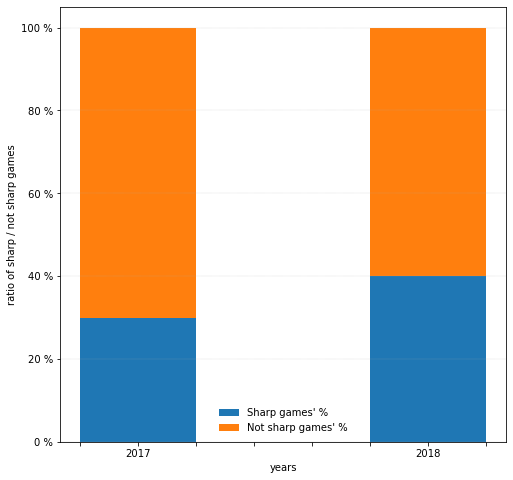

In [79]:
#displaying on stack column chart

#custom formatter for the chart 
def year_format_func(value, tick_number):
    # only return int years
    if value % (value // value) == 0:
        return int(value) 
    
def percent_format_func(value, tick_number):
    # return & of float
    return str(int(value * 100))+' %'
    

games_yearly_agg = games_yearly_agg.sort_values('year')
years = games_yearly_agg['year']
sharp = games_yearly_agg['sharp_ratio'].tolist()
not_sharp = games_yearly_agg['not_sharp_ratio'].tolist()

bar_width = 0.4
fig, axs = plt.subplots(1, 1, figsize=(8,8))

axs.bar(years, sharp, bar_width, label = "Sharp games' %")
axs.bar(years, not_sharp, bar_width,bottom=sharp, label = "Not sharp games' %")
axs.legend(frameon=False)
axs.set_xlabel('years')
axs.set_ylabel('ratio of sharp / not sharp games')
axs.xaxis.set_major_formatter(plt.FuncFormatter(year_format_func))
axs.yaxis.set_major_formatter(plt.FuncFormatter(percent_format_func))
axs.grid(axis='y', linestyle='dotted', linewidth = 0.4)